<a href="https://colab.research.google.com/github/rickycarrillo3/ML-Projects/blob/main/Gaussian_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome back! Today, we will implement the **Naive Bayes Classification Algorithm**. It is based off of Bayes' Rule from Statistics, and it aims to predict points' labels from training data.

In essence, we model each class (group of points with the same label) as a Gaussian random variable in space, and for a new point, we compute the probability that this new point is part of each of these distributions.


In [53]:
import numpy as np
import math
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Let's first generate a sample dataset.

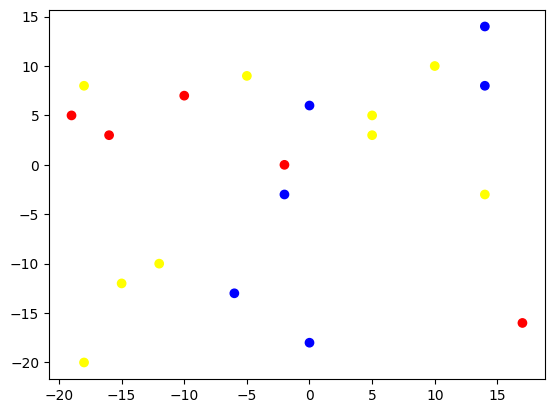

In [54]:
X = np.random.randint(-20, 20, (20, 2))
y = np.random.randint(0, 3, 20) # 3 classes
colors = {0: "blue", 1: "red", 2: "yellow"}
color_labels = [colors[label] for label in y]
# print(X)
# print(y)
# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=color_labels)
plt.show()

Let us write some functions to obtain the mean and standard deviations of each of our classes. These will help us obtain the respective probabilities of each class at test time.

In [55]:
'''
Compute the mean of the given class.
'''
def compute_class_mean(class_data):
    # In plain python
    # mean = [0 for i in range(len(class_data[0]))]
    # for example in class_data:
    #   for i in range(len(example)):
    #     mean[i] += example[i]
    # mean = [x / len(class_data) for x in mean]
    return np.mean(class_data, axis=0)


'''
Compute the standard deviation of the given class.
'''
def compute_class_std(class_data):
  # means = compute_class_mean(class_data)
  # # In plain python
  # n = len(class_data)
  # stds = [0 for i in range(len(class_data[0]))]
  # for example in class_data:
  #   for i in range(len(example)):
  #     stds[i] += (example[i] - means[i])**2
  # stds = [math.sqrt(x / n) for x in stds]
  return np.std(class_data, axis=0)

Oftentimes, when dealing with continuous features, we incorporate the assumption that these features follow a Gaussian distribution. In practice, we would need to look at the feature values to truly understand their distribution. In this demo, we will use the most common assumption of the feature values following a Gaussian distribution

Now, we can compute the mean and standard deviation of each class


In [56]:
class_stats = {}
for i in range(0,3):
  # Compute mean and std
  class_stats[i] = (compute_class_mean(X[y==i]), compute_class_std(X[y==i]))
print(class_stats)

{0: (array([ 3.33333333, -1.        ]), array([ 7.80313327, 11.48912529])), 1: (array([-6. , -0.2]), array([12.88409873,  8.23164625])), 2: (array([-3.77777778, -1.11111111]), array([11.83007258, 10.11538371]))}


Now, let's write the functions for the computation of the probability a point is in a specific class at test time. First, we need to review Bayes' Theorem

$P(C = i | X = x) = \frac{P(C = i)P(X = x| C = i)}{P(X = x)}$

where $C$ means the class. Let's break it down term by term.


- $P(C = i | X = x)$ is the probability the class is $i$ given the datapoint $x$.

- $P(C = i)$ is called the prior, and it is the intial probability that the class of a random point is $i$.

- $P(X = x| C = i)$ is the probability that a datapoint sampled from the $i$th class is equal to $x$.

- $P(X = x)$ is the probability a random datapoint sampled from our data distribution is $x$.

**Purpose**: To find the $i$ that maximizes $P(C = i|X = x)$

In the Naive Bayes approach, we assume that the conditional probabilities of each of the features are independent. Thus,

$P(X = x|C = i) = \prod_{j = 1}^{k}P(X_j = x_j|C = i)$

where $x = (x_1, x_2, ..., x_k)$ is the datapoint in question.

One important thing to notice is that for any of the points in our space, $P(X = x)$ is the exact same. Thus, we only really care about the numerator.

Then, we really want to compute

$P(C = i | X = x) \propto P(C = i)P(X = x| C = i) = P(C = i)\prod_{j = 1}^{k}P(X_j = x_j|C = i)$


The prior $P(C = i)$ can be calculated by taking the proportion of the points of the training data that belong to class $i$. We could also assume an uniformed prior where each class is equally likely. Then, we could ignore this probability.

$\prod_{j = 1}^{k}P(X_j = x_j|C = i)$ can be calculated in the following way:

Notice $P(X_j = x_j| C = i)$ can be estimated since we have the mean and standard deviation of this feature for class $i$.

$\prod_{j = 1}^{k}P(X_j = x_j|C = i) =
\prod_{j = 1}^{k} \frac{1}{\sigma_j\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-\mu_j}{\sigma_j}\right)^{\!2}\,\right)$


In [63]:
'''
Compute the probability of a given point belonging to a class.
'''
def compute_probability(prior_prob, class_mean, class_std, point):
  final_prob = 1
  for i in range(len(point)):
    element_i = point[i]
    class_mean_i = class_mean[i]
    class_std_i = class_std[i]
    final_prob *= (1 / (class_std_i * math.sqrt(2 * math.pi))) * math.exp(-0.5 * ((element_i - class_mean_i) / class_std_i) ** 2)
  return prior_prob * final_prob


'''
Predicts the class the point belongs to.
'''
def predict_class(point, class_stats, prior):
  # 3 is just the number of classes in this case
  class_probs = []
  for c in range(3):
    class_probs.append(compute_probability(prior[c], class_stats[c][0], class_stats[c][1], point))
  # Index with the largest probability
  # print(class_probs)
  return np.argmax(class_probs)


'''
Computes the accuracy given predictions and labels
'''
def compute_accuracy(preds, labels):
  correct = sum([p == y for p, y in zip(preds, labels)])
  return correct / len(preds)


Sweet, now we have all tools to make a prediction ! Let's now generate two datasets: a random one, and one made up of various Gaussians. In theory, our Gaussian Naive Bayes approach should perform better on the latter dataset as our assumption is built into the data, but we shall see...

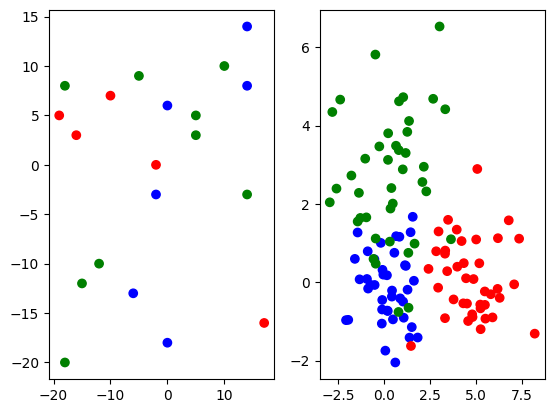

In [74]:
# Initialize plots
figure, axis = plt.subplots(1, 2)
### Dataset 1###
dataset_1 = X
labels_1 = y
colors = {0: "blue", 1: "red", 2: "green"}
color_labels = [colors[label] for label in labels_1]
# Plot the data
axis[0].scatter(dataset_1[:, 0], dataset_1[:, 1], c=color_labels)

### Dataset 2 ####
means = [[0, 0], [5, 0], [0, 3]]
stds = [np.identity(2), [[2, 0], [0 , 1]], [[3, 0], [0, 2]]]
# Initialize classes
class_0 = np.random.multivariate_normal(means[0], stds[0], 40)
class_1 = np.random.multivariate_normal(means[1], stds[1], 40)
class_2 = np.random.multivariate_normal(means[2], stds[2], 40)
dataset_2 = np.concatenate((class_0, class_1, class_2))
labels_2 = np.concatenate((np.zeros(40), np.ones(40), np.full(40, 2)))
color_labels_2 = [colors[label] for label in labels_2]
axis[1].scatter(dataset_2[:, 0], dataset_2[:, 1], c=color_labels_2)


In [75]:
# Train-test splits
dataset_1_train, dataset_1_test, labels_1_train, labels_1_test = train_test_split(dataset_1, labels_1, test_size=0.25, random_state=42)
dataset_2_train, dataset_2_test, labels_2_train, labels_2_test = train_test_split(dataset_2, labels_2, test_size=0.25, random_state=42)

# Collect stats from each class in the datasets
class_stats_1 = {}
for c_i in range(3):
  class_stats_1[c_i] = (compute_class_mean(dataset_1_train[labels_1_train==c_i]), compute_class_std(dataset_1_train[labels_1_train==c_i]))
prior_1 = [len(dataset_1_train[labels_1_train == i]) / len(dataset_1_train) for i in range(3)]

class_stats_2 = {}
for c_i in range(3):
  class_stats_2[c_i] = (compute_class_mean(dataset_2_train[labels_2_train==c_i]), compute_class_std(dataset_2_train[labels_2_train==c_i]))
prior_2 = [len(dataset_2_train[labels_2_train == i]) / len(dataset_2_train) for i in range(3)]

In [78]:
# Try classifying the testing data
predictions_1 = []
for point in dataset_1_test:
  predictions_1.append(predict_class(point, class_stats_1, prior_1))

predictions_2 = []
for point in dataset_2_test:
  predictions_2.append(predict_class(point, class_stats_2, prior_2))

print(f"Accuracy of Gaussian Naive Bayes on dataset 1: {compute_accuracy(predictions_1, labels_1_test)}")
print(f"Accuracy of Gaussian Naive Bayes on dataset 2: {compute_accuracy(predictions_2, labels_2_test)}")

Accuracy of Gaussian Naive Bayes on dataset 1: 0.4
Accuracy of Gaussian Naive Bayes on dataset 2: 0.9666666666666667


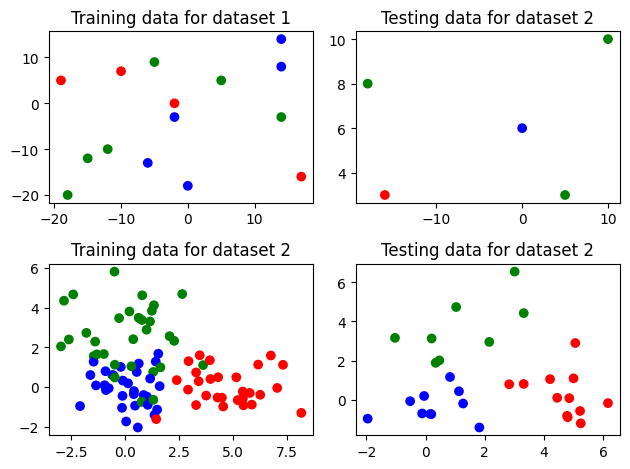

In [83]:
# Plot training and testing data
figure, axis = plt.subplots(2, 2)
axis[0,0].set_title("Training data for dataset 1")
axis[0,0].scatter(dataset_1_train[:, 0], dataset_1_train[:, 1], c=[colors[label] for label in labels_1_train])
axis[0,1].set_title("Testing data for dataset 2")
axis[0,1].scatter(dataset_1_test[:, 0], dataset_1_test[:, 1], c=[colors[label] for label in labels_1_test])
axis[1,0].set_title("Training data for dataset 2")
axis[1,0].scatter(dataset_2_train[:, 0], dataset_2_train[:, 1], c=[colors[label] for label in labels_2_train])
axis[1,1].set_title("Testing data for dataset 2")
axis[1,1].scatter(dataset_2_test[:, 0], dataset_2_test[:, 1], c=[colors[label] for label in labels_2_test])
# Avoid overlap
plt.tight_layout()

Nice ! We can see that when the underlying data does follow our assumptions, our classifier is very good. Some factors that could affect performance are overlap between classes and some correlation between the features. In addition, more training data would help us estimate the mean and standard deviation of the underlying distributions much better.

Finally, one additional note is that often the probabilities we computed in compute_probabilities are very small. Thus, it is often useful to take the log of that probability, and then we would have a sum of logarithms, which helps us avoid division by 0.

Thanks for taking your time to read this demo.